In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/regression_image_dataset.zip'  # Replace with actual zip path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Step 3: Set Paths
image_folder = '/content/dataset/images'  # change this path
csv_file = '/content/dataset/labels.csv'  # change this path

In [5]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Step 4: Load CSV and filter out 'undipped' (-1.0) rows
df = pd.read_csv(csv_file)
df = df[df['label'] != -1.0].reset_index(drop=True)  # Filter out label = -1.0

# Step 5: Load Images and Labels
image_size = (224, 224)
X, y = [], []

for index, row in df.iterrows():
    img_path = os.path.join(image_folder, row['filename'])  # column should be named 'filename'
    label = row['label']
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [7]:
# STEP 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Train set: (1728, 224, 224, 3) (1728,)
Validation set: (432, 224, 224, 3) (432,)


In [9]:
# Importing the libraries
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [10]:
# Loading my pretrained base models

resnet_model = load_model("resnet_trained.h5", compile=False)
mobilenet_model = load_model("mobilenet_trained.h5", compile=False)
densenet_model = load_model("densenet_trained.h5", compile=False)

print("All pretrained models loaded successfully!")

All pretrained models loaded successfully!


In [11]:
# Converting base models to embedding extractors

resnet_embedder = Model(
    inputs=resnet_model.input,
    outputs=resnet_model.layers[-2].output
)

mobilenet_embedder = Model(
    inputs=mobilenet_model.input,
    outputs=mobilenet_model.layers[-2].output
)

densenet_embedder = Model(
    inputs=densenet_model.input,
    outputs=densenet_model.layers[-2].output
)

In [12]:
# Generating embeddings for train and validation
train_res = resnet_embedder.predict(X_train, batch_size=32, verbose=1)
train_mob = mobilenet_embedder.predict(X_train, batch_size=32, verbose=1)
train_den = densenet_embedder.predict(X_train, batch_size=32, verbose=1)

val_res = resnet_embedder.predict(X_val, batch_size=32, verbose=1)
val_mob = mobilenet_embedder.predict(X_val, batch_size=32, verbose=1)
val_den = densenet_embedder.predict(X_val, batch_size=32, verbose=1)

print("Embedding Shapes:")
print(train_res.shape, train_mob.shape, train_den.shape)

54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 923ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Embedding Shapes:
(1728, 128) (1728, 128) (1728, 128)


In [13]:
# Combining embeddings
X_train_stack = np.concatenate([train_res, train_mob, train_den], axis=1)
X_val_stack   = np.concatenate([val_res, val_mob, val_den], axis=1)

print("Stacked Train Shape:", X_train_stack.shape)
print("Stacked Val Shape:", X_val_stack.shape)

Stacked Train Shape: (1728, 384)
Stacked Val Shape: (432, 384)


In [14]:
# The Meta learner - Final stacking model
input_dim = X_train_stack.shape[1]

stack_input = Input(shape=(input_dim,))

x = Dense(512, activation="relu")(stack_input)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

stack_output = Dense(1)(x)

stack_model = Model(inputs=stack_input, outputs=stack_output)

stack_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,545 (1.39 MB)

 Trainable params: 363,009 (1.38 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [15]:
# Compiling the stacking model
stack_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

In [16]:
# Training the stack model
callbacks = [
    EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=10, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_stacked_model.h5", save_best_only=True, monitor="val_mae", mode="min")
]

history = stack_model.fit(
    X_train_stack, y_train,
    validation_data=(X_val_stack, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
40/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.8092 - mae: 6.9768

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 53.3589 - mae: 6.7745 - val_loss: 17.5482 - val_mae: 4.0024 - learning_rate: 1.0000e-04
Epoch 2/300
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6705 - mae: 3.9697

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.1616 - mae: 3.8994 - val_loss: 4.5967 - val_mae: 1.6759 - learning_rate: 1.0000e-04
Epoch 3/300
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3537 - mae: 2.0685

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3122 - mae: 2.0590 - val_loss: 1.4385 - val_mae: 0.9006 - learning_rate: 1.0000e-04
Epoch 4/300
40/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7507 - mae: 1.7092

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7479 - mae: 1.7049 - val_loss: 0.8207 - val_mae: 0.7450 - learning_rate: 1.0000e-04
Epoch 5/300
41/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9651 - mae: 1.5483

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0641 - mae: 1.5668 - val_loss: 0.5820 - val_mae: 0.6300 - learning_rate: 1.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4068 - mae: 1.4313 - val_loss: 0.7006 - val_mae: 0.7025 - learning_rate: 1.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2313 - mae: 1.5910 - val_loss: 0.9163 - val_mae: 0.8216 - learning_rate: 1.0000e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0388 - mae: 1.3690 - val_loss: 1.3631 - val_mae: 1.0127 - learning_rate: 1.0000e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6819 - mae: 1.4891 - val_loss: 1.6387 - val_mae: 1.1364 - learning_rate: 1.0000e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0936 - mae: 1.3861 - val_loss: 1.1742 - val_mae: 0.9692 - learning_rate: 1.0000e-04
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7285 - mae: 1.2836 - val_loss: 1.5050 - val_mae: 1.1087 - learning_rate: 1.0000

In [17]:
# Evaluating the model performance

# Predictions
y_pred = stack_model.predict(X_val_stack).flatten()

# Metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_val - y_pred))
r2 = r2_score(y_val, y_pred)

print("------ STACK MODEL PERFORMANCE ------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
------ STACK MODEL PERFORMANCE ------
Mean Absolute Error (MAE): 0.6300
Mean Squared Error (MSE): 0.5820
Root Mean Squared Error (RMSE): 0.7629
R² Score: 0.9619


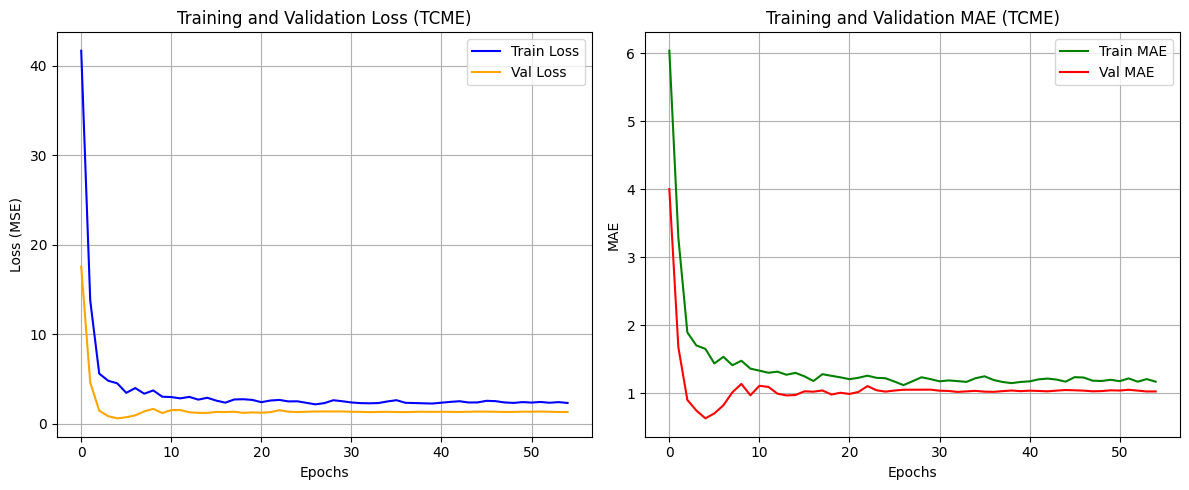

In [22]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (TCME)')
plt.legend()
plt.grid(True)

# Plot MAE
if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color='green')
    plt.plot(history.history['val_mae'], label='Val MAE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE (TCME)')
    plt.legend()
    plt.grid(True)
else:
    print("⚠️ MAE not found in history. Did you compile the model with `metrics=['mae']`?")

plt.tight_layout()
plt.savefig("resnet_loss_and_mae_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()


In [23]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': y_pred.flatten()})

# Save locally in Colab
csv_path = '/content/TCME_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

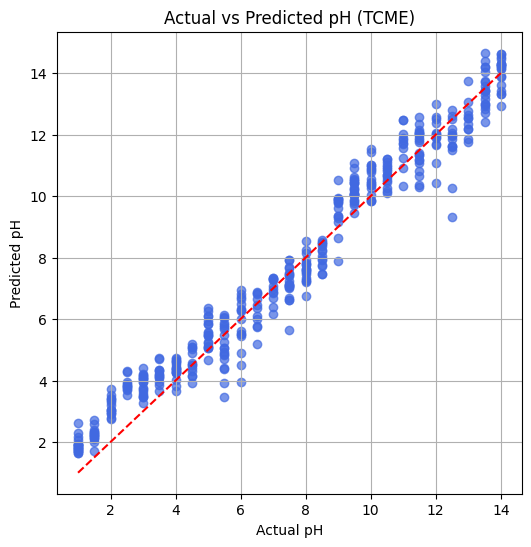

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.7, color='royalblue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs Predicted pH (TCME)")
plt.grid(True)
plt.savefig("TCME_actual_vs_predicted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

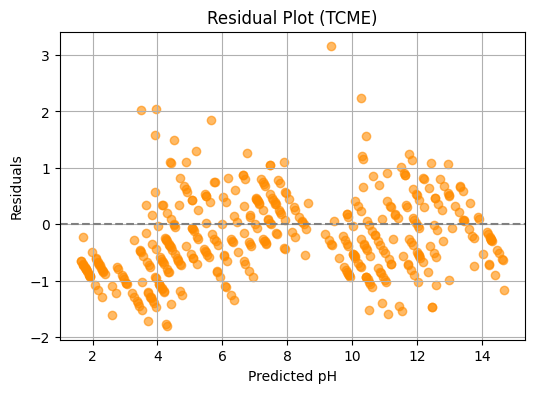

In [25]:
residuals = y_val - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pH")
plt.ylabel("Residuals")
plt.title("Residual Plot (TCME)")
plt.grid(True)
plt.savefig("TCME_residual_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

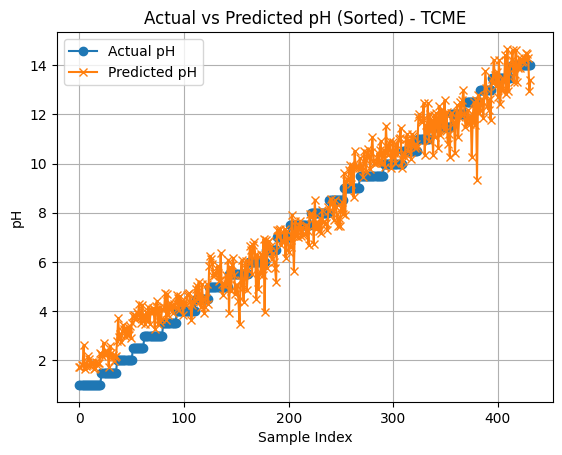

In [26]:
import numpy as np

sorted_indices = np.argsort(y_val)
plt.plot(np.array(y_val)[sorted_indices], label='Actual pH', marker='o')
plt.plot(y_pred[sorted_indices], label='Predicted pH', marker='x')
plt.title("Actual vs Predicted pH (Sorted) - TCME")
plt.xlabel("Sample Index")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.savefig("TCME_actualvspredicte_sorted.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

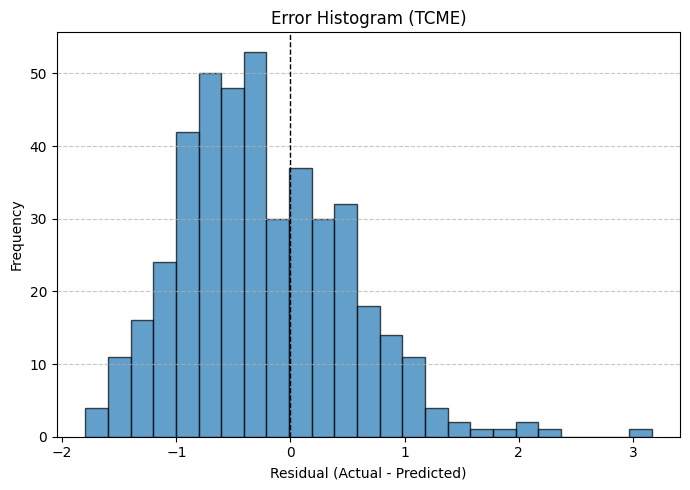

In [27]:
import matplotlib.pyplot as plt

# Residuals (errors)
residuals = y_val - y_pred

# Error histogram
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=25, edgecolor='black', alpha=0.7)
plt.axvline(0, color='k', linestyle='--', linewidth=1)  # reference line at 0
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Error Histogram (TCME)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("TCME_error_histogram.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

In [30]:
from tensorflow.keras.models import load_model
from google.colab import files

# Save the entire model
model_path = "TCME_regression_model.keras" # Changed to .keras format
stack_model.save(model_path)

# Download the model file
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>